In [1]:
import pandas as pd
from ydata_profiling import ProfileReport
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../data/raw/train.csv")
df1 = pd.read_csv("../data/raw/test.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
print("Shape",df.shape)
print("\nData Types\n",df.dtypes)
print("\nIsNullPresent\n",df.isnull().sum())
print("\nCheck Duplicates\n",df.duplicated().sum())
print("\nDescrib\n",df.describe(include='all'))

#checking correlation
df.corr(numeric_only=True)['Response'].sort_values(ascending=False)

Shape (381109, 12)

Data Types
 id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

IsNullPresent
 id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Check Duplicates
 0

Describ
                    id  Gender            Age  Driving_License    Region_Code  \
count   381109.000000  381109  381109.000000    381109.000000  381109.000000   
unique            NaN       2         

Response                1.000000
Age                     0.111147
Annual_Premium          0.022575
Region_Code             0.010570
Driving_License         0.010155
Vintage                -0.001050
id                     -0.001368
Policy_Sales_Channel   -0.139042
Previously_Insured     -0.341170
Name: Response, dtype: float64

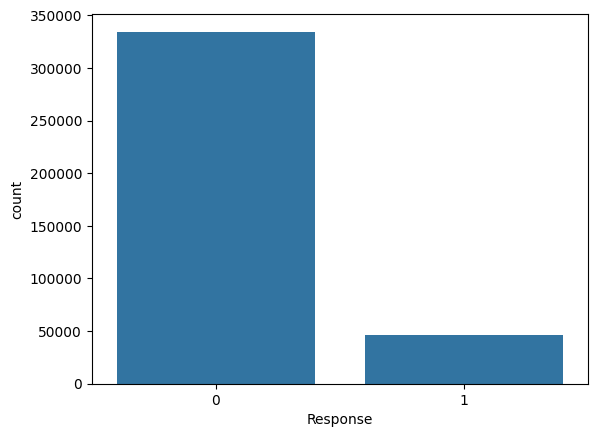

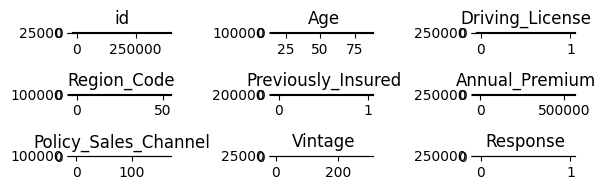

In [4]:
sns.countplot(x='Response', data=df)

df.hist(figsize=(6,2))
plt.tight_layout()

In [5]:
#Check for missing values - No missing values
# df.isnull().sum()
#Check for duplicates - No Duplicates
# df.duplicated().sum()

In [ ]:
#Fixing data types
# df.info()
df['Region_Code'] = df['Region_Code'].astype('Int64')
df['Annual_Premium'] = df['Annual_Premium'].astype('Int64')
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('Int64')
#df.info()

df1['Region_Code'] = df1['Region_Code'].astype('Int64')
df1['Annual_Premium'] = df1['Annual_Premium'].astype('Int64')
df1['Policy_Sales_Channel'] = df1['Policy_Sales_Channel'].astype('Int64')

In [7]:
df.nunique()

id                      381109
Gender                       2
Age                         66
Driving_License              2
Region_Code                 53
Previously_Insured           2
Vehicle_Age                  3
Vehicle_Damage               2
Annual_Premium           48838
Policy_Sales_Channel       155
Vintage                    290
Response                     2
dtype: int64

In [8]:
#Handiling Outliers
num_cols = ["Age", "Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]

def remove_outliers_iqr(data, columns):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data = data[(data[col]>=lower_bound) & (data[col]<=upper_bound)]
    return data

df = remove_outliers_iqr(df, num_cols)
df1 = remove_outliers_iqr(df1, num_cols)

print(f"Cleaned rows: {df.shape[0]}")
df.shape

Cleaned rows: 370789


(370789, 12)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 370789 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    370789 non-null  int64 
 1   Gender                370789 non-null  object
 2   Age                   370789 non-null  int64 
 3   Driving_License       370789 non-null  int64 
 4   Region_Code           370789 non-null  Int64 
 5   Previously_Insured    370789 non-null  int64 
 6   Vehicle_Age           370789 non-null  object
 7   Vehicle_Damage        370789 non-null  object
 8   Annual_Premium        370789 non-null  Int64 
 9   Policy_Sales_Channel  370789 non-null  Int64 
 10  Vintage               370789 non-null  int64 
 11  Response              370789 non-null  int64 
dtypes: Int64(3), int64(6), object(3)
memory usage: 37.8+ MB


In [10]:
#Logical Consistency check

# Removing impossible Age values
df = df[(df['Age'] >= 0) & (df['Age'] < 120)]
# Removing entries where Annual_Premium is zero or unrealistically high (>1 lakh)
df = df[(df['Annual_Premium'] > 1000) & (df['Annual_Premium'] < 100000)]
# Removing entries with invalid Vintage (usually time since policy, should be >0 and <500)
df = df[(df['Vintage'] > 0) & (df['Vintage'] < 500)]
# Ensuring Region_Code is within a valid range
valid_region_codes = df['Region_Code'].value_counts().index  # or define a static list
df = df[df['Region_Code'].isin(valid_region_codes)]
# Removing entries with unknown Gender (if such exist)
df = df[df['Gender'].isin(['Male', 'Female'])]
# Removing entries where Driving_License has invalid values (only 0 or 1)
df = df[df['Driving_License'].isin([0, 1])]
# Removing entries where Previously_Insured has invalid values
df = df[df['Previously_Insured'].isin([0, 1])]
# Vehicle_Age: keep only expected values
df = df[df['Vehicle_Age'].isin(['< 1 Year', '1-2 Year', '> 2 Years'])]
# Vehicle_Damage: must be 'Yes' or 'No'
df = df[df['Vehicle_Damage'].isin(['Yes', 'No'])]
# Policy_Sales_Channel: optionally filter rare channels if needed
valid_channels = df['Policy_Sales_Channel'].value_counts()[df['Policy_Sales_Channel'].value_counts() > 50].index
df = df[df['Policy_Sales_Channel'].isin(valid_channels)]

# Response: should be 0 or 1
df = df[df['Response'].isin([0, 1])]

print(f"Cleaned data shape: {df.shape}")

Cleaned data shape: (369800, 12)


In [12]:
#Logical Consistency check
#TEST
# Removing impossible Age values
df1 = df1[(df1['Age'] >= 0) & (df1['Age'] < 120)]
# Removing entries where Annual_Premium is zero or unrealistically high (>1 lakh)
df1 = df1[(df1['Annual_Premium'] > 1000) & (df1['Annual_Premium'] < 100000)]
# Removing entries with invalid Vintage (usually time since policy, should be >0 and <500)
df1 = df1[(df1['Vintage'] > 0) & (df1['Vintage'] < 500)]
# Ensuring Region_Code is within a valid range
valid_region_codes = df1['Region_Code'].value_counts().index  # or define a static list
df1 = df1[df1['Region_Code'].isin(valid_region_codes)]
# Removing entries with unknown Gender (if such exist)
df1 = df1[df1['Gender'].isin(['Male', 'Female'])]
# Removing entries where Driving_License has invalid values (only 0 or 1)
df1 = df1[df1['Driving_License'].isin([0, 1])]
# Removing entries where Previously_Insured has invalid values
df1 = df1[df1['Previously_Insured'].isin([0, 1])]
# Vehicle_Age: keep only expected values
df1 = df1[df1['Vehicle_Age'].isin(['< 1 Year', '1-2 Year', '> 2 Years'])]
# Vehicle_Damage: must be 'Yes' or 'No'
df1 = df1[df1['Vehicle_Damage'].isin(['Yes', 'No'])]
# Policy_Sales_Channel: optionally filter rare channels if needed
valid_channels = df1['Policy_Sales_Channel'].value_counts()[df1['Policy_Sales_Channel'].value_counts() > 50].index
df1 = df1[df1['Policy_Sales_Channel'].isin(valid_channels)]

print(f"Cleaned data shape: {df1.shape}")

Cleaned data shape: (122557, 11)


In [ ]:
# df.nunique()
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122557 entries, 0 to 127036
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    122557 non-null  int64 
 1   Gender                122557 non-null  object
 2   Age                   122557 non-null  int64 
 3   Driving_License       122557 non-null  int64 
 4   Region_Code           122557 non-null  Int64 
 5   Previously_Insured    122557 non-null  int64 
 6   Vehicle_Age           122557 non-null  object
 7   Vehicle_Damage        122557 non-null  object
 8   Annual_Premium        122557 non-null  Int64 
 9   Policy_Sales_Channel  122557 non-null  Int64 
 10  Vintage               122557 non-null  int64 
dtypes: Int64(3), int64(5), object(3)
memory usage: 11.6+ MB


In [15]:
df.to_csv("../data/processed/cleaned_v1.csv",index=False)
df1.to_csv("../data/processed/test_v1.csv",index=False)


In [ ]:
# #Using profiling tool for analysis
# profile_path = os.path.abspath("../reports/eda_report.html")
# profile = profile = ProfileReport(
#     df,
#     title="Insurance Fraud Detection - EDA Report",
#     explorative=True,
#     correlations={"pearson": True, "spearman": True, "kendall": False},
#     missing_diagrams={"heatmap": True, "dendrogram": False},
#     interactions={"continuous": True},
#     duplicate={"head": 10},
#     sort=None
# )
# Path(os.path.dirname(profile_path)).mkdir(parents=True, exist_ok=True)

# profile.to_file(profile_path)
# print("Profiling Completed")